In [1]:
import scipy.io
import scipy.spatial
import scipy.interpolate
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import os

import numpy as np

import datafold.dynfold as dfold
import datafold.pcfold as pfold
import datafold.utils

import sklearn

import pandas as pd

from os import listdir
from os.path import isfile, join

from large_eigensystems import *

In [2]:
# all parameters

n_delays = 100

n_skip_first = 2200
plot_shift = 27

n_common_evecs = 10
n_kernel_evecs = 1000
k_neighbors = 25

im_size =(15,15)

pathbase = os.path.join(os.path.expanduser("~"), "Documents/postdoc-repo2")
# pathbase = r"C:/Users/felix/Documents/postdoc-repo"

filepath_positions = os.path.join(pathbase, "projects/workspace/blender/rotation_objects")
filepath_images1 = os.path.join(pathbase, "projects/workspace/blender/rotation_objects/renders_car")
filepath_images2 = os.path.join(pathbase, "projects/workspace/blender/rotation_objects/renders_top2")

number of files: 11099
number of files: 11099
image size 1 (400, 300)
image size 2 (400, 300)


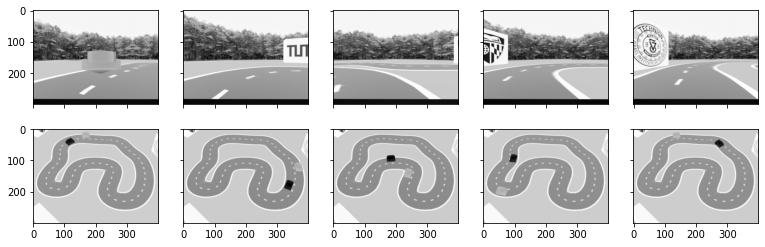

In [3]:

files1 = sorted([join(filepath_images1,f) for f in listdir(filepath_images1) if isfile(join(filepath_images1, f))])
files2 = sorted([join(filepath_images2,f) for f in listdir(filepath_images2) if isfile(join(filepath_images2, f))])

print("number of files:", len(files1))
print("number of files:", len(files2))

im_shape_large1 = Image.open(files1[0]).size
print("image size 1", im_shape_large1)

fig,ax = plt.subplots(2,5,figsize=(13,4),sharex=True,sharey=True)
for k in range(ax.shape[1]):
    ax[0, k].imshow(np.array(ImageOps.grayscale(Image.open(files1[n_skip_first+plot_shift*k+2]).resize(im_shape_large1,Image.ANTIALIAS))) / 255.0, cmap="gray")
    
im_shape_large2 = Image.open(files1[0]).size
print("image size 2", im_shape_large2)

for k in range(ax.shape[1]):
    ax[1, k].imshow(np.array(ImageOps.grayscale(Image.open(files2[n_skip_first+plot_shift*k+2]).resize(im_shape_large2,Image.ANTIALIAS))) / 255.0, cmap="gray")

fig.savefig("figures/carrace_data.pdf")

In [4]:
# process all data

# scale down for all images
#im_shape_large1 = (im_shape_large1[0]//2, im_shape_large1[1]//2)
#im_shape_large2 = (im_shape_large2[0]//2, im_shape_large2[1]//2)

def process_files(filesx, _im_size):
    data_allx = []
    for file in filesx:
        img = Image.open(file)
        img_smallx = np.array(ImageOps.grayscale(img.resize(_im_size,Image.ANTIALIAS))) / 255.0
        data_allx.append(img_smallx.flatten())
    return data_allx

data_all1 = process_files(files1, im_size)
data_all2 = process_files(files2, im_size)
data_all1 = np.row_stack(data_all1)
data_all2 = np.row_stack(data_all2)

In [5]:
# convert to time series

def process_images(data_all):
    data_small = data_all[n_skip_first:,:]

    df = pd.DataFrame(data_small, index=np.linspace(0,1,data_small.shape[0]))
    tsc = pfold.TSCDataFrame.from_single_timeseries(df)

    # setup processing pipeline and fit
    data_pipe = sklearn.pipeline.Pipeline([
        (
            "pca1",
            dfold.TSCPrincipalComponent(n_components=10),
        ),
        (
            "takens",
            dfold.TSCTakensEmbedding(delays=n_delays, kappa=0.0),
        ),
        (
            "pca2",
            dfold.TSCPrincipalComponent(n_components=5),
        ),
    ])

    data_pipe.fit(tsc)
    components = data_pipe.transform(tsc)
    return components

components1 = process_images(data_all1)
components2 = process_images(data_all2)

In [6]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1,projection="3d")
ax.scatter(components1["pca0"], components1["pca1"],components1["pca2"], s=10, c=np.linspace(0,1,components1.shape[0]), cmap="jet")
ax=fig.add_subplot(1,2,2,projection="3d")
ax.scatter(components2["pca0"], components2["pca1"],components2["pca2"], s=10, c=np.linspace(0,1,components2.shape[0]), cmap="jet")

In [7]:
# read in sensor2: positions
data_positions = np.genfromtxt(os.path.join(filepath_positions, "car_positions.txt"), delimiter=" ")

fig,ax = plt.subplots(1,1)
ax.scatter(*data_positions[:,:2].T, s=1)

sensor 1 (8799, 5)
sensor 2 (8799, 5)


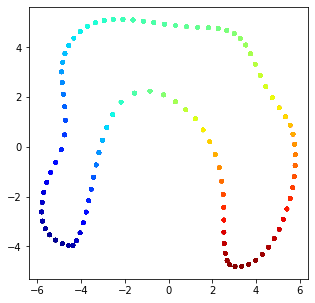

In [8]:
# define sensors

# rng = np.random.default_rng(12345)
# noise_level = 1e-1
# def noise(_data, _level):
#     return rng.normal(loc=0, scale=_level, size=_data.shape)

#sensordata_1 = data_positions[:components["pca0"].shape[0],:2].copy()
#sensordata_1 = sensordata_1 + noise(sensordata_1, noise_level)

sensordata_1 = np.array(components1).copy()
sensordata_2 = np.array(components2).copy()
#sensordata_2 = sensordata_2 + noise(sensordata_2, noise_level*1e-2)


#pcm = pfold.PCManifold(sensordata_1)
#pcm.optimize_parameters()
#_, indices = pfold.pcm_subsample(pcm, min_distance=pcm.cut_off*5, n_samples=10000)

#sensordata_1 = sensordata_1[indices,:]
#sensordata_2 = sensordata_2[indices,:]

print("sensor 1", sensordata_1.shape)
print("sensor 2", sensordata_2.shape)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(*data_positions[:components1["pca0"].shape[0],:2].T, s=10, c=sensordata_2[:,0], cmap='jet')

In [9]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax.scatter(*sensordata_2[:,:2].T, s=1,
           c=sensordata_1[:,0], cmap="jet")

In [10]:
# compute jointly smooth functions

def compute_evecs(_data, _n_evecs, kernel_type="gaussian", k_neighbors=None):
    print(f"Computing {_n_evecs} eigenvectors for data of size {_data.shape}...", end=" ")
    
    pcm = pfold.PCManifold(_data)
    pcm.optimize_parameters(result_scaling=10)
    
    if kernel_type == "cknn":
        if k_neighbors is None:
            k_neighbors = 25
        kernel = pfold.ContinuousNNKernel(delta=1.0, k_neighbor=k_neighbors)
        dist_kwargs = {"backend":"scipy.kdtree", "cut_off": pcm.cut_off, "kmin": kernel.k_neighbor}
        res, _ = kernel(_data, dist_kwargs=dist_kwargs)
    else:
        kernel = pcm.kernel
        dist_kwargs = {"backend":"scipy.kdtree", "cut_off": pcm.cut_off}
        res = kernel(_data, dist_kwargs=dist_kwargs)
        
    print("Optimized parameters...", end=" ")
    
    #dmap = dfold.DiffusionMaps(n_eigenpairs=_n_evecs, kernel=kernel,
    #                           dist_kwargs=dist_kwargs)
    #dmap.fit(pcm)
    #evecs_, evals_ = dmap.eigenvectors_, dmap.eigenvalues_
    
    res = 1/2 * scipy.sparse.csr_matrix(res + res.T)
    #res = scipy.sparse.diags(np.sqrt(np.array(1/res.sum(axis=0))).ravel(), 0) @ res @ scipy.sparse.diags(np.sqrt(np.array(1/res.sum(axis=0))).ravel(), 0)
    res = scipy.sparse.diags(np.array(1/res.sum(axis=0)).ravel(), 0) @ res
    res.eliminate_zeros()
    
    Aevals,Aevecs = scipy.sparse.linalg.eigsh(res, k=_n_evecs, which="LM")
    evals_,evecs_ = CommonEigensystemMatrix._sort_eigensystem(None, Aevals, Aevecs)
    
    print("Done.")
    return evecs_, evals_, res

# eigenvectors 1
evecs1, evals1, kernel1 = compute_evecs(sensordata_1, _n_evecs=n_kernel_evecs, kernel_type="gaussian", k_neighbors=k_neighbors)
# eigenvectors 2
evecs2, evals2, kernel2 = compute_evecs(sensordata_2, _n_evecs=n_kernel_evecs, kernel_type="gaussian", k_neighbors=k_neighbors)

Computing 1000 eigenvectors for data of size (8799, 5)... Optimized parameters... Done.
Computing 1000 eigenvectors for data of size (8799, 5)... Optimized parameters... Done.


In [11]:
# regular svd is much faster than sparse svd if the number of eigenvectors is large
# (i.e. the matrix is fully occupied, no zeros)
evecs_c, evals_c, _ = scipy.linalg.svd(np.column_stack([evecs1, evecs2]), full_matrices=False)
evals_c, evecs_c = CommonEigensystemMatrix._sort_eigensystem(None, evals_c, evecs_c)
evecs_c = evecs_c[:,:n_common_evecs]
evals_c = evals_c[:n_common_evecs]
print(evals_c)

[1.41421356 1.41421331 1.41421323 1.41421253 1.4142123  1.41421092
 1.41421068 1.41420885 1.41420868 1.41420585]


In [12]:
# plot segmented images

selected_evec = 1
selected_k = 15
selected_idx = 100
selected_evecs_c = evecs_c[selected_idx, :]
evec_kd = scipy.spatial.cKDTree(evecs_c)
_, evec_idx = evec_kd.query(selected_evecs_c, k=selected_k)
#evec_idx = np.arange(evecs_c.shape[0])

fig,ax = plt.subplots(1,1)
ax.scatter(*data_positions[:components1["pca0"].shape[0],:2].T, s=.1, c="b", cmap='jet')
ax.scatter(*data_positions[:components1["pca0"].shape[0],:2][evec_idx,:][:,:2].T, s=50, c="r", cmap='jet')

In [13]:

fig,ax = plt.subplots(1,4,figsize=(15,5))
ax[0].scatter(*data_positions[:components1["pca0"].shape[0],:2].T, s=10, c=evecs_c[:,2], cmap='jet')
ax[1].scatter(*data_positions[:components1["pca0"].shape[0],:2].T, s=10, c=evecs_c[:,1], cmap='jet')
ax[2].scatter(*(evecs_c[:,[1,2]]  ).T, s=10, c=sensordata_1[:,0], cmap='jet')
ax[3].scatter(*(evecs_c[:,[1,3]] ).T, s=10, c=sensordata_1[:,1], cmap='jet')

In [14]:
# image segmentation based on the jointly smooth functions

data_small_large2 = process_files(files2, im_shape_large1)[n_skip_first:]
_data = data_small_large2[n_delays:]

In [80]:
select_idx = 31
_im_shape_large = (int(im_shape_large1[1]),int(im_shape_large1[0]))

def segment_element(select_idx, select_k=5):
    select_evec_c = evecs_c[select_idx,:]
    _, select_neighbors = scipy.spatial.cKDTree(evecs_c).query(select_evec_c, k=select_k)
    _data_select = np.row_stack([_data[i] for i in select_neighbors])
    
    _segmented = np.mean(_data_select, axis=0) - np.mean(_data, axis=0)
    _segmented = _segmented - np.min(_segmented)
    _segmented = _segmented / np.max(_segmented)
    _segmented = 1.0 * (_segmented>.6) + 0.0 * (_segmented<.6)
    return _segmented, select_neighbors

alpha_segment, selected_neighbors = segment_element(select_idx)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(_data[select_idx].reshape(_im_shape_large)*0+.75, vmin=0, vmax=1, cmap="Greens")
#ax[0].imshow(_data[select_idx].reshape(_im_shape_large), cmap="gray", alpha=alpha_segment.reshape(_im_shape_large))
ax[0].imshow(np.mean(np.row_stack([_data[i] for i in selected_neighbors]),axis=0).reshape(_im_shape_large), cmap="gray", alpha=alpha_segment.reshape(_im_shape_large))

ax[1].imshow(np.array(ImageOps.grayscale(Image.open(files1[select_idx+n_skip_first+n_delays]).resize(im_shape_large1,Image.ANTIALIAS))) / 255.0, cmap="gray")

ax[2].scatter(*data_positions[:len(_data),:2].T, s=1, c="k")
ax[2].scatter(*data_positions[selected_neighbors+n_delays,:2].T, s=10, c="r")
ax[2].set_aspect(3/4)

fig.tight_layout()
fig.savefig("figures/carrace_segmentation.pdf")

In [70]:
# manifold learning of the common eigenfunctions
pcm = pfold.PCManifold(evecs_c)
print(pcm.shape)
pcm.optimize_parameters(result_scaling=10)
pcm.kernel.epsilon = 1e-2
dist_kwargs = {"backend": "scipy.kdtree", "cut_off": pcm.cut_off}

#k_neighbor = 50
#kmin = k_neighbor
#pcm.kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=k_neighbor, delta=.25)
#dist_kwargs = {"backend": "scipy.kdtree","kmin": kmin, "cut_off": 1e-10}

dmaps = dfold.DiffusionMaps(kernel=pcm.kernel, n_eigenpairs=10, dist_kwargs=dist_kwargs)
dmaps.fit(pcm)

evecs, evals = dmaps.eigenvectors_, dmaps.eigenvalues_

(8799, 10)


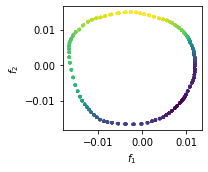

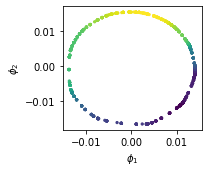

In [90]:
fig,ax = plt.subplots(1,evecs_c.shape[1],figsize=(15,2),sharey=True)

vmin,vmax = np.min(evecs_c), np.max(evecs_c)

n_plot_pts = 1000
size_marker = 5

for k in range(evecs_c.shape[1]):
    ax[k].scatter(*data_positions[:n_plot_pts,:2].T, vmin=vmin,vmax=vmax, s=size_marker, c=evecs_c[:n_plot_pts,k], )
    ax[k].set_xlabel(r"$x_1$")
    if k == evecs_c.shape[1]-1:
        ax[k].set_ylabel(r"$x_2$")

fig.tight_layout()

fig.savefig("figures/carrace_positions_evecs.pdf")

fig,ax = plt.subplots(1,1,figsize=(3,2.5))
ax.scatter(*evecs_c[:n_plot_pts,[1,2]].T, s=size_marker, c=data_positions[:n_plot_pts,0], )
ax.set_xlabel(r"$f_1$")
ax.set_ylabel(r"$f_2$")

fig.tight_layout()
fig.savefig("figures/carrace_jsf_positions.pdf")

fig,ax = plt.subplots(1,1,figsize=(3,2.5))
ax.scatter(*dmaps.eigenvectors_[:n_plot_pts,[1,2]].T, s=size_marker, c=data_positions[:n_plot_pts,0], )
ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

fig.tight_layout()
fig.savefig("figures/carrace_dmap_evecs_positions.pdf")

fig,ax = plt.subplots(1,1,figsize=(4,2.5))
ax.semilogy(dmaps.eigenvalues_, 'x-', color="blue", label="dmap" )
ax.semilogy(evals_c/np.sqrt(2), 'x-', color="orange",label="jsf" )
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\lambda_k$")
ax.legend(loc="center left")

fig.tight_layout()
fig.savefig("figures/carrace_dmap_evals.pdf")

fig,ax = plt.subplots(1,2,figsize=(6,2.5),sharey=True)
ax[0].scatter(*data_positions[:n_plot_pts,:2].T, s=size_marker, c=dmaps.eigenvectors_[:n_plot_pts,1], )
ax[0].set_xlabel(r"$x_1$")
ax[0].set_ylabel(r"$x_2$")
ax[1].scatter(*data_positions[:n_plot_pts,:2].T, s=size_marker, c=dmaps.eigenvectors_[:n_plot_pts,2], )
ax[1].set_xlabel(r"$x_1$")

fig.tight_layout()
fig.savefig("figures/carrace_positions_dmaps.pdf")

In [34]:
# compare to alternating diffusion
t0 = time()
kxy = kernel1 @ kernel2

print(f"Time to compute kernel: {time()-t0}")
print("Kernel size", kxy.shape)

t0 = time()
# regular svd is much faster than sparse svd if the number of eigenvectors is large
n_common_evecs = 10
evecs_adm, evals_adm, _ = scipy.sparse.linalg.svds(kxy, k=n_common_evecs)
#evecs_adm, evals_adm, _ = scipy.linalg.svd(kxy.todense(), full_matrices=False)

print(f"Time to compute sparse svd: {time()-t0}")

Time to compute kernel: 22.921594858169556
Kernel size (8799, 8799)
Time to compute sparse svd: 4.580398082733154


(8799, 10)


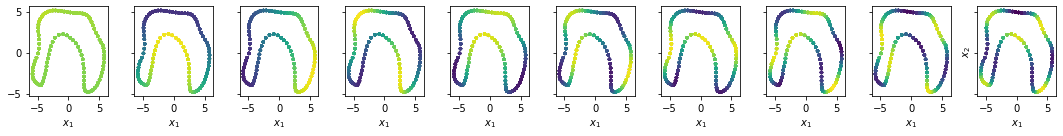

In [43]:
evals_adm, evecs_adm = CommonEigensystemMatrix._sort_eigensystem(None, evals_adm, evecs_adm)
evecs_adm = evecs_adm[:,:n_common_evecs]
evals_adm = evals_adm[:n_common_evecs]

print(evecs_adm.shape)

fig,ax = plt.subplots(1,evecs_c.shape[1],figsize=(15,2),sharey=True)
vmin,vmax = np.min(evecs_adm), np.max(evecs_adm)

for k in range(evecs_c.shape[1]):
    ax[k].scatter(*data_positions[:n_plot_pts,:2].T, vmin=vmin,vmax=vmax, s=size_marker, c=evecs_adm[:n_plot_pts,k], )
    ax[k].set_xlabel(r"$x_1$")
    if k == evecs_c.shape[1]-1:
        ax[k].set_ylabel(r"$x_2$")

fig.tight_layout()

fig,ax = plt.subplots(1,1,figsize=(3,2.5))
ax.scatter(*evecs_adm[:n_plot_pts,[1,2]].T, s=size_marker, c=data_positions[:n_plot_pts,0], )
ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

fig.tight_layout()